#### Checking multiple NLP models. The objective is to find the least complex and quickest-to-compute model with highest F1 score. The task was to classify innocent communications versus conduct risk related communications.  Domain is financial services.


#### Task was reduced to a binary classification problem with a total of 130k sentences. Class labels are balanced.

#### Models are as follows:
1. Model one:Embedding matrix with one dimensional CNN,Max pooling and LSTM.
2. Model two:Embedding matrix with multilayered LSTM and fully connected layers.
3. Model three:Embedding matrix with LSTM and multilayered GRU.
4. Model four:Gridsearch CV(Count Vectorizer/TFIDF with SGD classifier(log/hinge)loss). 
5. Model five:TFIDF with fully connected neural network.
6. Model six:Embedding matrix with fully connected neural network.

#### Communications of interest relates to the following conduct risk triggers.  
1.  Broker misrepresentation
2.  Client dissatisfaction
3.  Evassiveness
4.  Possible disclosure issues
5.  Possible trader spoofing

#### Results(F1 scores). Models are  ranked below from highest F1 score to lowest.  Less interested in accuracy metric given the context.  Highest ranking models are also relatively least complex. Generally scores are very similar but some models are much more complex and computationally expensive than others.
1. Model five:0.9999237
2. Model six:0.9999231 
3. Model one:0.9998463 
4. Model three:0.9998079 
5. Model two:0.9997696
6. Model four:0.9997607(mean)

##### Footnote; Data is modelled at sentence level and for this experiment in the spirit of time efficiency each net was trained over no more than 10 epochs and on no less than batch sizes of 100 sentences. Each net had the same parameters applied for any reductions in the learning rate. Allowing for all layers to be updated during training in each neural net.

#### Dec/2018

In [28]:
#Tensorflow
import tensorflow as tf 

#Pandas
import pandas as pd
from pandas import read_csv

#Numpy
import numpy as np
from numpy import array
from array import array
from numpy import argmax
from numpy import zeros

#Scipy
import scipy as sp
from scipy import interp

#Randoms
import os
from tqdm import tqdm 
from itertools import cycle
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import string

#Matplotlib  
%matplotlib inline
import matplotlib.pyplot as plt

#SK Learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.preprocessing import label_binarize
from sklearn import cluster
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import normalize
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
   
#Keras
import keras
from keras.engine import Input
from keras.models import Model
from keras.layers.merge import dot
from keras.utils import plot_model
from keras import backend as K
from keras import callbacks
from keras import layers
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import TimeDistributed
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Masking
from keras import regularizers
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout, Input
from keras.layers.noise import GaussianNoise
from keras.layers import LSTM
from keras import optimizers
from keras import regularizers

#NLTK for Count Vectorizer and TFIDF models. 
import nltk 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk import wordpunct_tokenize
from textblob import TextBlob, Word
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
 
#Lemmatizer
class LemmaTokenizer(object):     
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
    
#Print Confusion matrix and F1 score
def print_metrics(self,y):
    pred_round_1 = np.round(self, decimals=0,out=None)
    f1 = f1_score(y, pred_round_1,average='binary')
    con_1= confusion_matrix(y, pred_round_1)
    print(con_1)
    print(f1)
    
#Plot model convergence path    
def plot_model(self):
    plt.plot(self.history['acc'])
    plt.plot(self.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()   
    plt.plot(self.history['loss'])
    plt.plot(self.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show() 

In [2]:
#Read in data
test = pd.read_csv('/Users/brianfarrell/Desktop/test_client_dissatisfaction.csv',encoding='utf8')
training = pd.read_csv('/Users/brianfarrell/Desktop/sentences_2.csv',encoding='utf8') 
test.drop(columns='Misconduct_type',inplace=True)
result = pd.concat([test,training], ignore_index=True)

values = {'Label_bin': 0}
result.fillna(value=values,inplace=True)  

In [3]:
#Resample classes 
#Noise(sentences not of interest)
training_majority = result[result.Label_bin==0]
#Signal(sentences of interest)
training_minority = result[result.Label_bin==1]
 
#Upsample minority class
training_minority_upsampled = resample(training_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=65000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([training_majority, training_minority_upsampled])
 
#df_upsampled.shape
result = df_upsampled  

In [4]:
#Prep for word embedding matrix
#Tokenize,pad and encode.
t = Tokenizer()
docs= result['Sentences']
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
#Print(encoded_docs)
#Pad documents to a max length of 15 words
max_length = 15
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
vocab_size
labels = result['Label_bin'] 

In [5]:
#Train/Test 80/20
X_train, X_test, y_train, y_test = train_test_split(padded_docs,labels, test_size=0.20, shuffle=True)

In [6]:
#Check shapes and baseline
print ("Train/test shapes")
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Baseline label check")
print(y_test.value_counts())

Train/test shapes
(104380, 15) (26096, 15) (104380,) (26096,)
Baseline label check
0.0    13078
1.0    13018
Name: Label_bin, dtype: int64


### Model one:  One dimension CNN layer, Max Pooling and LSTM layer. Dropout, L2 Regularization and learning rate reduction on any plateau in validation loss level.

In [7]:
#Starting with one dimensional Convolutional layer
#1st LSTM layer has some dropout,initializing weights with glorot normalizations
#2nd LSTM has same normalisation used for initialization but also has l2 regularisation.
#Reducing larning rate on plateau on validation loss level.
 

labels= result['Label_bin']



model_1 = Sequential()

#Embedding layer
#Emedding weights not frozen during training
e = Embedding(vocab_size, 200, input_length=max_length,trainable=True)
model_1.add(e)

#1D CNN
#Testing narrower normalization of initializer as default has wider normalisation tolerance.
c = Conv1D(filters=20, kernel_size=15,padding='same',  kernel_initializer='glorot_normal', activation='relu')
model_1.add(c)

#Maxpool
mp= MaxPooling1D(pool_size=2)
model_1.add(mp)
              
#LSTM 1st layer
ls1= LSTM(100, input_shape=(15, 1),kernel_initializer='glorot_normal',
          return_sequences=True,activation='relu',dropout=0.1,
          recurrent_dropout=0.1)
model_1.add(ls1)
              
#LSTM 2nd layer, testing narrower normalization of initializer.Using regularisation just in this layer.
ls2= LSTM(100, input_shape=(15, 1),kernel_initializer='glorot_normal',activation='relu',kernel_regularizer=regularizers.l2(0.5), 
           bias_regularizer=regularizers.l2(0.5),activity_regularizer=regularizers.l2(0.5),
          recurrent_regularizer=regularizers.l2(0.5))
model_1.add(ls2)

#Final fully Connected Dense layer 
d = Dense(1, activation='sigmoid')
model_1.add(d)

#Using reduce learning rate on val_loss plateau with a patience of one Epoch
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.15, 
                                  patience=1, verbose=2, mode='auto', cooldown=0, min_lr=0.00001)

 


#Compile ,fit model and evaluate on test data.
model_1.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
  
history_1 = model_1.fit(X_train, y_train, epochs=10, callbacks=[lr],batch_size=100, 
           validation_split=0.20, shuffle=True, verbose=2)
 
model_1.evaluate(X_test, y_test, verbose=2,batch_size=100)

pred_cnn = model_1.predict(X_test, batch_size=100,verbose=2)

Train on 83504 samples, validate on 20876 samples
Epoch 1/10
 - 47s - loss: 28.2021 - acc: 0.9334 - val_loss: 6.7106 - val_acc: 0.9999
Epoch 2/10
 - 45s - loss: 2.4018 - acc: 0.9997 - val_loss: 0.7153 - val_acc: 0.9998
Epoch 3/10
 - 45s - loss: 0.5284 - acc: 0.9998 - val_loss: 0.7091 - val_acc: 0.9998
Epoch 4/10
 - 44s - loss: 0.4231 - acc: 0.9993 - val_loss: 0.5484 - val_acc: 0.9998
Epoch 5/10
 - 44s - loss: 0.3649 - acc: 1.0000 - val_loss: 0.7075 - val_acc: 0.9999

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 6/10
 - 44s - loss: 0.3319 - acc: 0.9998 - val_loss: 0.3259 - val_acc: 0.9998
Epoch 7/10
 - 43s - loss: 0.3222 - acc: 1.0000 - val_loss: 0.3207 - val_acc: 0.9999
Epoch 8/10
 - 45s - loss: 0.3152 - acc: 1.0000 - val_loss: 0.3176 - val_acc: 0.9999
Epoch 9/10
 - 45s - loss: 0.3083 - acc: 1.0000 - val_loss: 0.3116 - val_acc: 0.9999
Epoch 10/10
 - 46s - loss: 0.3015 - acc: 1.0000 - val_loss: 0.3048 - val_acc: 0.9999


In [8]:
model_1.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 200)           78000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 20)            60020     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            48400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 266,921
Trainable params: 266,921
Non-trainable params: 0
_________________________________________________________________


In [9]:
print_metrics(pred_cnn,y_test)

[[13074     4]
 [    0 13018]]
0.9998463901689708


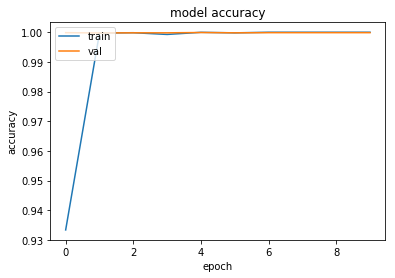

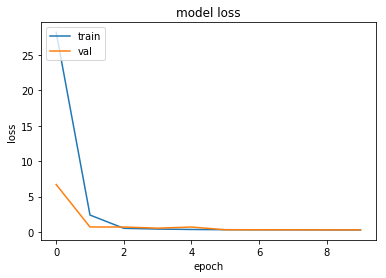

In [10]:
plot_model(history_1)

### Model two: Two  LSTM layers with small amount of dropout and reduction on plateau applied during training. Reducing dimensionality through the net into final layer.

In [11]:
#LSTM layers
model_2 = Sequential()


#Add embedding layer, allow for layer to retrain
e = Embedding(vocab_size, 200, input_length=15, trainable=True)
model_2.add(e)

#LSTM first layer
model_2.add(LSTM(200, input_shape=(15,1),kernel_initializer='glorot_normal',return_sequences=True,activation='relu',
               dropout=0.15))

#LSTM second layer,reducing dimensions
model_2.add(LSTM(100,kernel_initializer='glorot_normal',activation='relu',
               dropout=0.15))

#Dense layer, 1st, reducing dimensions again
model_2.add(Dense(50,kernel_initializer='glorot_normal',activation='relu'))

#Dense layer,final layer
model_2.add(Dense(1, activation='sigmoid'))
          
#Reducing learning rate on a Val loss plateau  
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.15, 
                                  patience=1, verbose=2, mode='auto', cooldown=0, min_lr=0.00001) 
          
#Compile ,fit and evaluate the model
model_2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
 
#Fit the model
history_2 = model_2.fit(X_train, y_train, callbacks=[lr], validation_split=0.2, shuffle=True, epochs=10, verbose=2,batch_size=100)

#Evaluate the model
model_2.evaluate(X_test, y_test, verbose=2,batch_size=100)

pred_ldense = model_2.predict(X_test, batch_size=100,verbose=2)

Train on 83504 samples, validate on 20876 samples
Epoch 1/10
 - 76s - loss: 0.0240 - acc: 0.9894 - val_loss: 0.0027 - val_acc: 0.9998
Epoch 2/10
 - 72s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0050 - val_acc: 0.9995

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 3/10
 - 73s - loss: 7.2596e-04 - acc: 0.9999 - val_loss: 0.0036 - val_acc: 0.9997

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.2500001068692655e-05.
Epoch 4/10
 - 73s - loss: 5.8854e-04 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 0.9997

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 5/10
 - 73s - loss: 5.8379e-04 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 0.9997
Epoch 6/10
 - 72s - loss: 5.8356e-04 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 0.9997
Epoch 7/10
 - 78s - loss: 5.7969e-04 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 0.9997
Epoch 8/10
 - 79s - loss: 5.7706e-04 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 0.9997
Epoch 9/10
 - 77s - loss: 

In [12]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 200)           78000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 200)           320800    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 524,301
Trainable params: 524,301
Non-trainable params: 0
_________________________________________________________________


In [13]:
print_metrics(pred_ldense,y_test)

[[13072     6]
 [    0 13018]]
0.9997696029490822


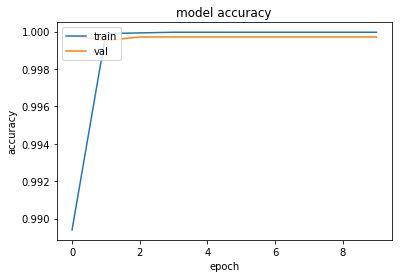

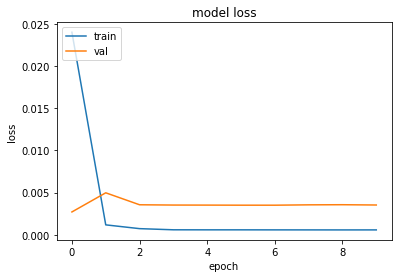

In [14]:
plot_model(history_2) 

### Model three: Combining LSTM  with multiple GRU layers. Dropout and regularization applied to first LSTM layer followed by GRU layers with dimensionality reduced into final Dense layer.

In [15]:
#LSTM with l2 regularisation and multiple GRU layers
 
model_3 = Sequential()

#Add embedding layer, not frozen during training
e = Embedding(vocab_size, 200, input_length=15, trainable=True)
model_3.add(e)

#LSTM layer
ls_tm =  LSTM(200, input_shape=(15,1),activation='tanh', recurrent_activation='hard_sigmoid', 
                  use_bias=True,kernel_initializer='glorot_normal', 
                  recurrent_initializer='orthogonal', bias_initializer='zeros', 
                  unit_forget_bias=True, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01), 
                  bias_regularizer=regularizers.l2(0.01), activity_regularizer=None, kernel_constraint=None,
                  recurrent_constraint=None, bias_constraint=None, dropout=0.25, recurrent_dropout=0.25, 
                  implementation=1, return_sequences=True, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False)
model_3.add(ls_tm)


#Adding GRU layer and reducing dimensions
rnn_gru = GRU(100, kernel_initializer='glorot_normal',return_sequences=True)
model_3.add(rnn_gru)

#Adding second GRU layer with fewer dimensions again
small_gru = GRU(50,kernel_initializer='glorot_normal',return_sequences=True)
model_3.add(small_gru)

#third and final GRU with even smaller dimensions
smaller_gru = GRU(15,kernel_initializer='glorot_normal')
model_3.add(smaller_gru)

#Final fully connected layer 
model_3.add(Dense(1, activation='sigmoid'))


#Reducing learning rate on val loss plateau          
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.15, 
                                  patience=1, verbose=2, mode='auto', cooldown=0, min_lr=0.000001) 
          
#Compile,fit and evaluate the model.Checking Adagrad optimizer vs Adam on same loss function.
model_3.compile(optimizer= 'Adagrad', loss='binary_crossentropy', metrics=['acc'])
 
#fit the model
history_3 = model_3.fit(X_train, y_train, callbacks=[lr], validation_split=0.2, shuffle=True, epochs=10, verbose=2,batch_size=100)

#evaluate the model
model_3.evaluate(X_test, y_test, verbose=2,batch_size=100)

pred_k = model_3.predict(X_test, batch_size=1,verbose=2)
 

Train on 83504 samples, validate on 20876 samples
Epoch 1/10
 - 99s - loss: 0.9615 - acc: 0.9944 - val_loss: 0.5188 - val_acc: 0.9996
Epoch 2/10
 - 96s - loss: 0.3522 - acc: 0.9998 - val_loss: 0.2344 - val_acc: 0.9997
Epoch 3/10
 - 95s - loss: 0.1684 - acc: 0.9998 - val_loss: 0.1171 - val_acc: 0.9996
Epoch 4/10
 - 94s - loss: 0.0852 - acc: 0.9998 - val_loss: 0.0623 - val_acc: 0.9997
Epoch 5/10
 - 95s - loss: 0.0438 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 0.9997
Epoch 6/10
 - 96s - loss: 0.0243 - acc: 0.9998 - val_loss: 0.0178 - val_acc: 0.9998
Epoch 7/10
 - 96s - loss: 0.0123 - acc: 1.0000 - val_loss: 0.0100 - val_acc: 0.9998
Epoch 8/10
 - 96s - loss: 0.0074 - acc: 0.9998 - val_loss: 0.0351 - val_acc: 0.9962

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0014999999664723873.
Epoch 9/10
 - 96s - loss: 0.0109 - acc: 0.9996 - val_loss: 0.0108 - val_acc: 0.9995

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00022500000195577739.
Epoch 10/10
 - 95s - loss: 0.00

In [16]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 15, 200)           78000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 15, 200)           320800    
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 100)           90300     
_________________________________________________________________
gru_2 (GRU)                  (None, 15, 50)            22650     
_________________________________________________________________
gru_3 (GRU)                  (None, 15)                2970      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 16        
Total params: 514,736
Trainable params: 514,736
Non-trainable params: 0
_________________________________________________________________


In [17]:
print_metrics(pred_k,y_test) 

[[13073     5]
 [    0 13018]]
0.9998079950846742


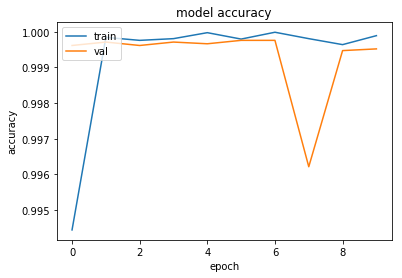

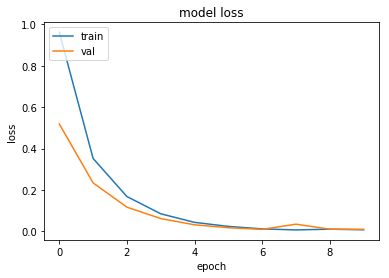

In [18]:
plot_model(history_3) 

### Model four: 5-fold cross-validated Gridseach Pipeline(Count Vectorizer/TFIDF feeding into SGD classifier with (log/hinge loss function) 

In [19]:
#Build pipe and gridseach with cross validation.Upstream: count vectorisation/TDIDF and downstream:
#SGD classifier with log(logistic regression) loss and hinge(SVM) loss functions to choose from. 

#Build pipe
pipeline = Pipeline([
    ('vect', CountVectorizer(input='content', encoding='utf-8', decode_error='strict', 
              strip_accents=None, lowercase=True, preprocessor=None, tokenizer=LemmaTokenizer(), 
              stop_words='english', analyzer='word', vocabulary=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=100))])

#Define parameters and ranges for Gridsearch.
parameters = {
    'vect__max_df': (0.75, 1.0), # Checking removal of common words at two treshold levels
    'vect__ngram_range': ((1, 1), (1, 2)), # Checking unigram vs bigram  
    'tfidf__use_idf': (True, False), #Checking if IDF penalty has an effect or not   
    'clf__loss': ('hinge', 'log')} # Checking Logistic vs Support Vector classifier

#Define parameters for Gridsearch with five fold cross validation.
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='f1',
                               n_jobs=-1, verbose=1,return_train_score=True)
 
#Fit pipe
grid_search.fit(docs, labels)
print("Best F1 score: %0.3f" % grid_search.best_score_)

#Select and print best parameters  
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
#Retrive all scores in Gridsearch and put into a Dataframe. 
df= pd.DataFrame(grid_search.cv_results_)

#Print mean F1 score and its standard deviation. 
gs_score= df['mean_test_score'] 
mu= gs_score.mean()
s= gs_score.std()
 
print("Gridsearch F1 score(mean): %0.7f" % mu)
print("Gridsearch F1 score(std dev): %0.7f" % s)    

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 19.2min finished


Best f1 score: 1.000
	clf__loss: 'hinge'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
Gridsearch f1 score(mean): 0.9997607
Gridsearch f1 score(std dev): 0.0000733


### Model five: TFIDF matrix passed to fully connected neural network.

In [20]:
#Model with Document term matrix(dtm) and two fully connected layers.

#Get TDIDF scores. Convert all to lowercase and Lemmatize.   
vect = TfidfVectorizer(stop_words='english', 
                       lowercase=True, preprocessor= None,
                       analyzer= u'word', 
                       ngram_range=(1, 1), max_df=0.75, 
                       max_features=200, 
                       use_idf=True, 
                       smooth_idf=True,
                       tokenizer= LemmaTokenizer(),
                       sublinear_tf=False)

vect.fit(result['Sentences'])

dtm = pd.DataFrame(vect.transform(result['Sentences']).todense(),
                       columns=vect.get_feature_names()) 
#Normalize DTM for net
dtm_n= normalize(dtm)
 
#Split data for this model.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(dtm_n,labels, test_size=0.20, shuffle=True)
print("Baseline label check")
print(y_test_2.value_counts())
 


#Fully connected Neural Net
model_5 = Sequential()

#First layer is Dense
model_5.add(Dense(200,  input_dim=200, kernel_initializer='glorot_normal',activation='relu'))

#Last layer is Dense 
model_5.add(Dense(1, activation='sigmoid'))
          
#Reduce learning rate if val loss stalls 
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.15, 
                                  patience=1, verbose=2, mode='auto', cooldown=0, min_lr=0.000001)
          
#Compile,fit and evaluate the model
model_5.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
  
#Fit the model
history_5 = model_5.fit(X_train_2, y_train_2, callbacks=[lr], validation_split=0.2, shuffle=True, epochs=10, verbose=2,batch_size=100)
#Evaluate the model
model_5.evaluate(X_test_2,y_test_2, verbose=2,batch_size=100)

pred_dense_5 = model_5.predict(X_test_2, batch_size=100,verbose=2)

Baseline label check
1.0    13115
0.0    12981
Name: Label_bin, dtype: int64
Train on 83504 samples, validate on 20876 samples
Epoch 1/10
 - 4s - loss: 0.0598 - acc: 0.9944 - val_loss: 0.0028 - val_acc: 0.9998
Epoch 2/10
 - 2s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0018 - val_acc: 0.9998
Epoch 3/10
 - 2s - loss: 7.1011e-04 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9998

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 4/10
 - 2s - loss: 5.5893e-04 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9998

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.2500001068692655e-05.
Epoch 5/10
 - 2s - loss: 5.2985e-04 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9998

Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.3750000511645338e-06.
Epoch 6/10
 - 2s - loss: 5.2473e-04 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9998

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 7/10
 - 2s - loss: 5.2373e-04 - acc: 0.9999

In [21]:
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 40,401
Trainable params: 40,401
Non-trainable params: 0
_________________________________________________________________


In [22]:
print_metrics(pred_dense_5,y_test_2)  

[[12979     2]
 [    0 13115]]
0.9999237572430619


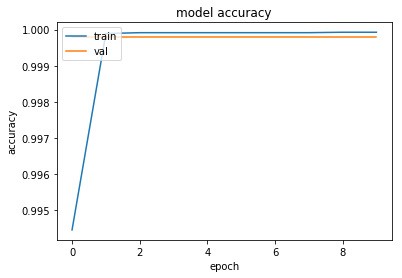

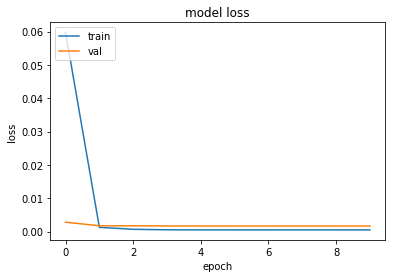

In [23]:
plot_model(history_5) 

### Model six:  Embedding matrix passed to fully connected neural network. No dropout or regularization used but learning rate is reduced on any plateau in the validation loss level.

In [24]:
model_6 = Sequential()

#Add Embedding layer not frozen during training
e = Embedding(vocab_size, 200, input_length=15, trainable=True)
model_6.add(e)

#Flatten embedding output to connect to First Fully Connected Dense layer
model_6.add(Flatten())
model_6.add(Dense(200,  input_dim=200, kernel_initializer='glorot_normal',activation='relu'))

#Final fully connected layer
model_6.add(Dense(1, activation='sigmoid'))
          
#Reducing learning rate on a val loss plateau 
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.15, 
                                  patience=1, verbose=2, mode='auto', cooldown=0, min_lr=0.000001)

#Compile,fit and evaluate the model
model_6.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
 
#Fit the model
history_6 = model_6.fit(X_train, y_train, callbacks=[lr], validation_split=0.2, shuffle=True, epochs=10, verbose=2,batch_size=100)
#Evaluate the model
model_6.evaluate(X_test,y_test, verbose=2,batch_size=100)

pred_dense_6 = model_6.predict(X_test, batch_size=100,verbose=2)

Train on 83504 samples, validate on 20876 samples
Epoch 1/10
 - 14s - loss: 0.0148 - acc: 0.9950 - val_loss: 0.0084 - val_acc: 0.9999
Epoch 2/10
 - 13s - loss: 7.4871e-05 - acc: 1.0000 - val_loss: 8.0993e-04 - val_acc: 0.9999
Epoch 3/10
 - 13s - loss: 4.5389e-06 - acc: 1.0000 - val_loss: 9.0813e-04 - val_acc: 0.9999

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 4/10
 - 14s - loss: 2.7551e-06 - acc: 1.0000 - val_loss: 9.1609e-04 - val_acc: 0.9999

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.2500001068692655e-05.
Epoch 5/10
 - 14s - loss: 2.5615e-06 - acc: 1.0000 - val_loss: 9.1798e-04 - val_acc: 0.9999

Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.3750000511645338e-06.
Epoch 6/10
 - 14s - loss: 2.5194e-06 - acc: 1.0000 - val_loss: 9.1872e-04 - val_acc: 0.9999

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 7/10
 - 14s - loss: 2.5111e-06 - acc: 1.0000 - val_loss: 9.1881e-04 - val_acc: 0.9999
Epoc

In [25]:
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 15, 200)           78000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               600200    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 678,401
Trainable params: 678,401
Non-trainable params: 0
_________________________________________________________________


In [26]:
print_metrics(pred_dense_6,y_test)  

[[13076     2]
 [    0 13018]]
0.9999231891850373


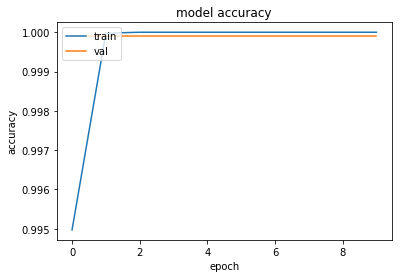

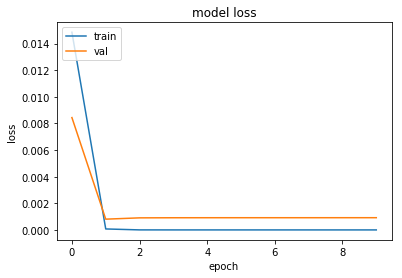

In [27]:
plot_model(history_6)  